# Introduction

We will use [Adult dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/) to build a logistic regression model to predict the probability a person will make more than 50K a year.

The dataset has the following fields:

    age: continuous.
    workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
    fnlwgt: continuous.
    education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
    education-num: continuous.
    marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
    occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
    relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
    race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
    sex: Female, Male.
    capital-gain: continuous.
    capital-loss: continuous.
    hours-per-week: continuous.
    native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.
    
As in real data, we have both categorical data and numerical (continous) data. 

Note that the field ``fnlwgt`` is final weight. This weight accounts for difference in demographic background of each person:

    People with similar demographic characteristics should have
    similar weights.  There is one important caveat to remember
    about this statement.  That is that since the CPS sample is
    actually a collection of 51 state samples, each with its own
    probability of selection, the statement only applies within
    state.
    
    


# Scurbbing and cleaning


In [80]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict

plt.rcParams['figure.figsize'] = (12,6)

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import fmin_powell
from scipy import integrate

import theano as thno
import theano.tensor as T

In [78]:
def run_models(df, upper_order=5):
    '''
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity.
    Suggest limit to max order 5 since calculation time is exponential.
    '''

    models, traces = OrderedDict(), OrderedDict()

    for k in range(1,upper_order+1):

        nm = 'k{}'.format(k)
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print('\nRunning: {}'.format(nm))
            pm.glm.GLM.from_formula(fml, df, family=pm.glm.families.Normal())

            traces[nm] = pm.sample(2000, chains=1, init=None, tune=1000)

    return models, traces

def plot_traces(traces, retain=1000):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.df_summary(traces[-retain:]).iterrows()})

    for i, mn in enumerate(pm.df_summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

def create_poly_modelspec(k=1):
    '''
    Convenience function:
    Create a polynomial modelspec string for patsy
    '''
    return ('income ~ educ + hours + age ' + ' '.join(['+ np.power(age,{})'.format(j)
                                     for j in range(2,k+1)])).strip()

In [3]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", header=None, names=['age', 'workclass', 'fnlwgt',
                'education-categorical', 'educ',
                'marital-status', 'occupation',
                'relationship', 'race', 'sex',
                'captial-gain', 'capital-loss',
                'hours', 'native-country',
                'income'])

In [4]:
data.head(10)

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


First we need to remove any null entries in ``income`` field and restrict this study to the United States.

We also need to remove leading and trailing spaces in the ``native-country`` field. This makes sure successful comparison.

In [23]:
data = data[~pd.isnull(data['income'])]
data['native-country'] = data['native-country'].str.strip()

In [33]:
data = data[data['native-country'] == "United-States"]

In [35]:
data.shape

(29170, 15)

In [45]:
income = 1 * (data['income'] == ' >50K')
age2 = np.square(data['age'])

In [48]:
data = data[['age', 'educ', 'hours']]
data['age2'] = age2
data['income'] = income

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Exploring data

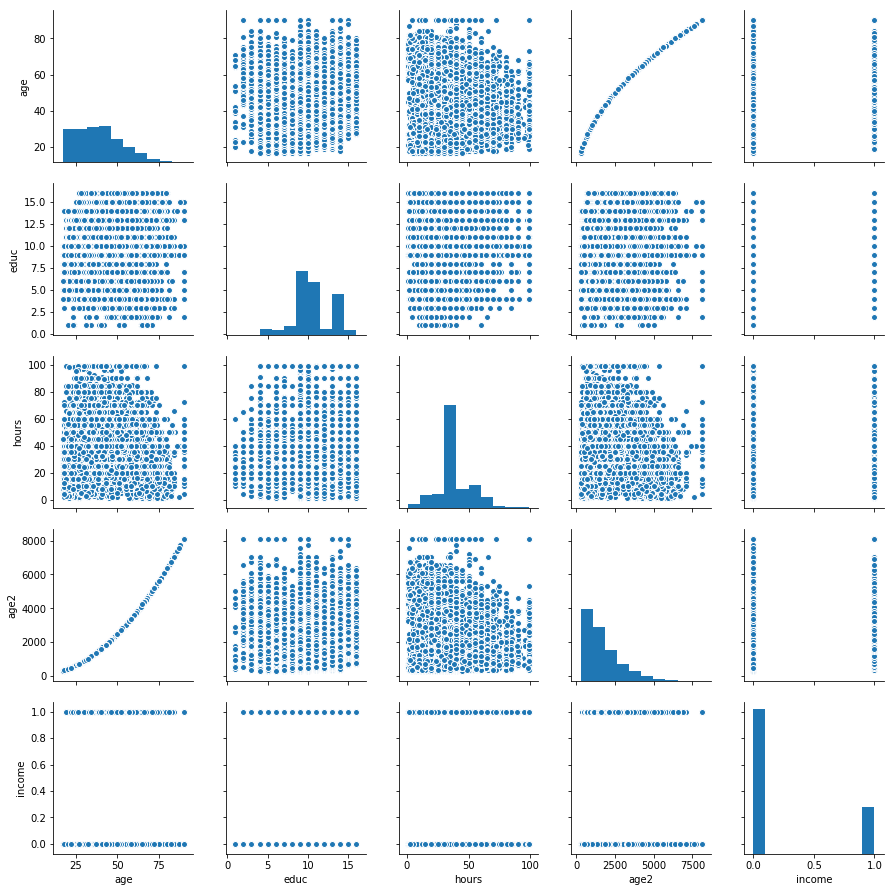

In [51]:
g = sns.pairplot(data)

We can see that age has a tailed distribution. We do not see much correlaiton between features except between age and age2.

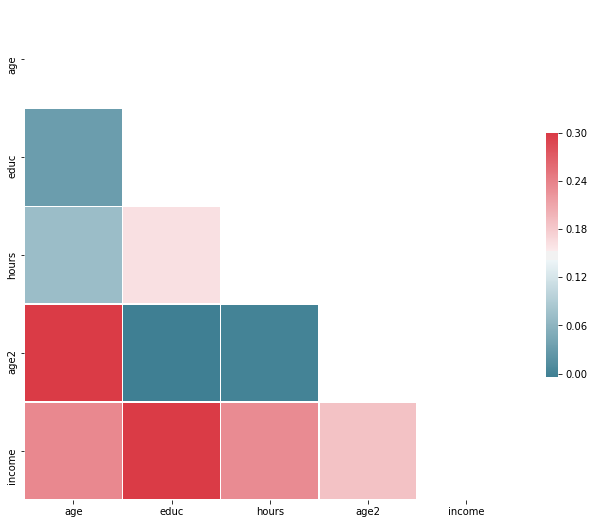

In [71]:
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11,9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, mask=mask, cbar_kws= {'shrink': .5}, ax=ax, vmax=0.3, linewidths=.5)

In [90]:
data.educ

0        13
1        13
2         9
3         7
5        14
7         9
8        14
9        13
10       10
12       13
13       12
16        9
17        9
18        7
19       14
20       16
21        9
22        5
23        7
24        9
25       13
26        9
28        9
29        9
30       12
31       10
32       13
33       10
34       10
36       10
         ..
32528     9
32529     9
32530    13
32531    13
32532    16
32534    10
32535     8
32536    13
32537     9
32538    13
32539    16
32540     9
32541     9
32542     9
32543    12
32544    14
32545    12
32546    12
32548    15
32549    10
32550    10
32551     6
32552    11
32554    14
32555    10
32556    12
32557     9
32558     9
32559     9
32560     9
Name: educ, Length: 29170, dtype: int64

# Bayesian logistic regression

If we denote $\theta$ as the regression coefficients then its Bayesian inference is as follows: 
$$p(\theta \mid \cal{D})= \frac{p(\cal{D} \mid \theta)p(\theta)}{p(\cal{D})}$$

The denominator is difficult to compute since it involves integration on the domain of $\theta$. We prefer to skip it. That is we are interested in computing only the numerator. This is done by performing sampling on the posterior distribution and making inference about it.

The sampling algorithm used is NUTS, which is a form of Hamiltonial Monte Carlo, in which parameters are tuned automatically. 

We will use PyMC3 for our Bayesian inference. 

The default prior $p(\theta) = \cal{N}(0,10^{12}I)$. This is a very vague prior that will let the data speak for themselves.

The likelihood is the product of n Bernoulli trails: $\prod_{i=1}^{n}p_i^y(1-p_i)^{1-y_i}$, where $p_i = \frac{1}{1 + e^{-z_i}}$ where $$z_i = \beta_0 + \beta_1age_i^2 + \beta_3educ_i + \beta_4hours_i$$

Note that $y_i = 1$ if income is greater than 50K and $y_i = 0$ otherwise.

In [81]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('income ~ age + age2 + educ + hours', data, family=pm.glm.families.Binomial())
    trace_logistic_model = pm.sample(2000, chains=1, tune=1000)

100%|██████████| 3000/3000 [22:00<00:00,  2.27it/s]


# Some results


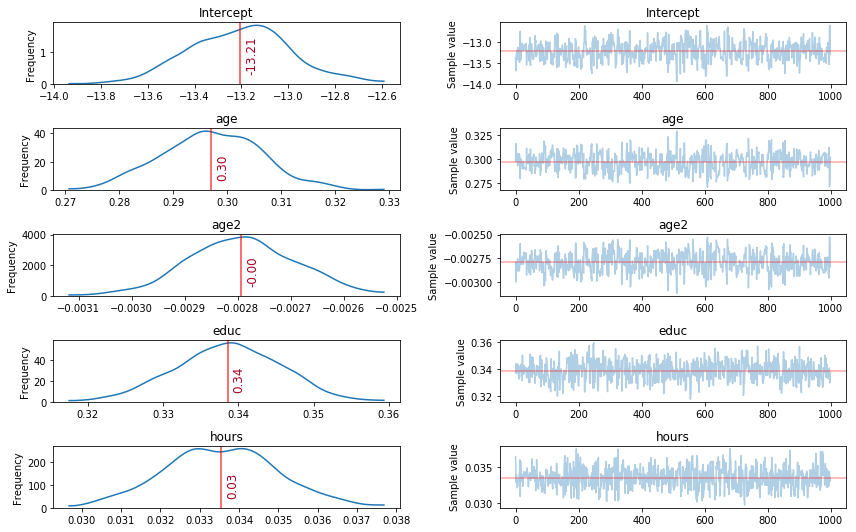

In [88]:
plot_traces(trace_logistic_model, retain=1000)


Contratry to point estimate such as MLE or MAP, Bayesian inference is worth the computation time because we can provide information about how certain we are about our parameter values. 

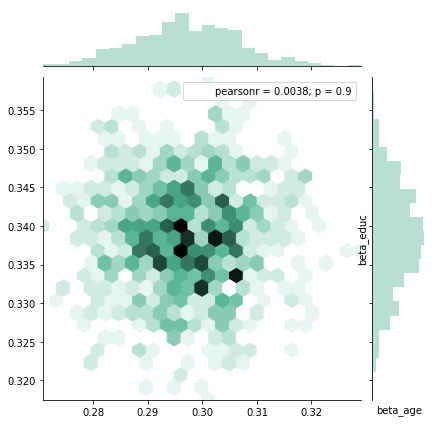

In [87]:
plt.figure(figsize=(9,7))
trace = trace_logistic_model[1000:]
sns.jointplot(trace['age'], trace['educ'], kind="hex", color="#4CB391")
plt.xlabel("beta_age")
plt.ylabel("beta_educ")
plt.show()

How do age and education affect the probability of making more than 50K?

To answer this question, we can show how the probability of making more than 50K changes with age for a few different education levels? Here we assume the number of hours worked per week is fixed at 50. PyMC3 provides a convenient way to plot the posterior predictive distribution $p(y\mid x, \theta)$

We have three linear models:

- educ == 12 (finished highschool)
- educ == 16 (finished undergrad)
- educ == 19 (three years of grad school)

In [92]:
# Linear model with hours == 50 and educ == 12
lm = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] +
                                          samples['age']*x +
                                          samples['age2']*np.square(x) +
                                          samples['educ']*12 +
                                          samples['hours']*50)))

# Linear model with hours == 50 and educ == 16
lm2 = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] +
                                          samples['age']*x +
                                          samples['age2']*np.square(x) +
                                          samples['educ']*16 +
                                          samples['hours']*50)))

# Linear model with hours == 50 and educ == 19
lm3 = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] +
                                          samples['age']*x +
                                          samples['age2']*np.square(x) +
                                          samples['educ']*19 +
                                          samples['hours']*50)))

Each curve shows how the probability of earning more than $ 50K$ changes with age. The red curve represents 19 years of education, the green curve represents 16 years of education and the blue curve represents 12 years of education. For all three education levels, the probability of making more than $50K increases with age until approximately age 60, when the probability begins to drop off. Notice that each curve is a little blurry. This is because we are actually plotting 100 different curves for each level of education. Each curve is a draw from our posterior distribution. Because the curves are somewhat translucent, we can interpret dark, narrow portions of a curve as places where we have low uncertainty and light, spread out portions of the curve as places where we have somewhat higher uncertainty about our coefficient values.

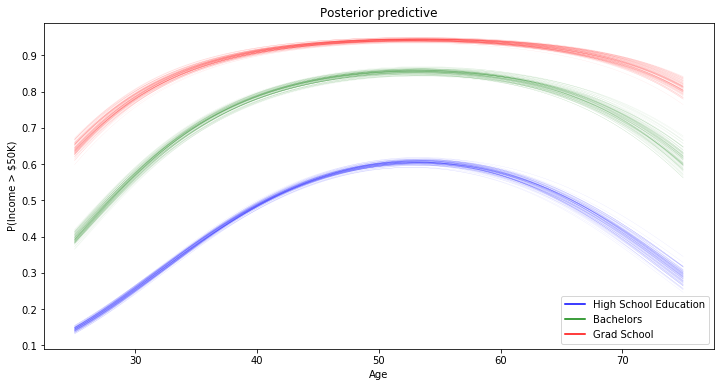

In [93]:
# Plot the posterior predictive distributions of P(income > $50K) vs. age
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25, 75, 1000), lm=lm, samples=100, color="blue", alpha=.15)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25, 75, 1000), lm=lm2, samples=100, color="green", alpha=.15)
pm.plot_posterior_predictive_glm(trace, eval=np.linspace(25, 75, 1000), lm=lm3, samples=100, color="red", alpha=.15)
import matplotlib.lines as mlines
blue_line = mlines.Line2D(['lm'], [], color='b', label='High School Education')
green_line = mlines.Line2D(['lm2'], [], color='g', label='Bachelors')
red_line = mlines.Line2D(['lm3'], [], color='r', label='Grad School')
plt.legend(handles=[blue_line, green_line, red_line], loc='lower right')
plt.ylabel("P(Income > $50K)")
plt.xlabel("Age")
plt.show()

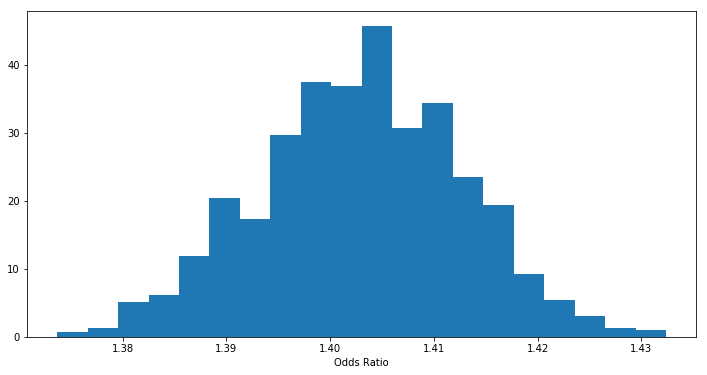

In [95]:
b = trace['educ']
plt.hist(np.exp(b), bins=20, normed=True)
plt.xlabel("Odds Ratio")
plt.show()

Plotting credible interval.

In [98]:
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
print("P(%.3f < O.R. < %.3f) = 0.95"%(np.exp(3*lb),np.exp(3*ub)))


P(2.648 < O.R. < 2.876) = 0.95


# Model selection

One question that was immediately asked was what effect does age have on the model, and why should it be age2
versus age? We’ll run the model with a few changes to see what effect higher order terms have on this model in terms of WAIC.

In [99]:
models_lin, traces_lin = run_models(data, 4)



Running: k1


100%|██████████| 3000/3000 [01:14<00:00, 40.17it/s]



Running: k2


100%|██████████| 3000/3000 [02:50<00:00, 17.60it/s]



Running: k3


100%|██████████| 3000/3000 [11:45<00:00,  4.25it/s]



Running: k4


100%|██████████| 3000/3000 [42:07<00:00,  1.19it/s]


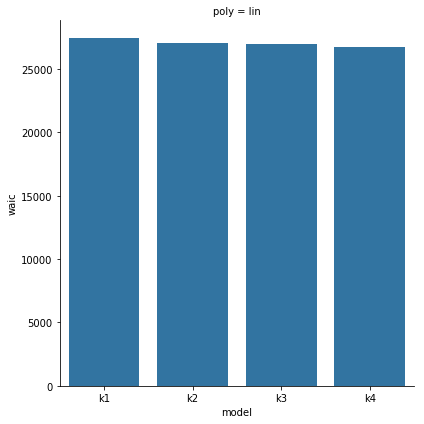

In [100]:
dfwaic = pd.DataFrame(index=['k1','k2','k3','k4'], columns=['lin'])
dfwaic.index.name = 'model'

for nm in dfwaic.index:
    dfwaic.loc[nm, 'lin'] = pm.waic(traces_lin[nm],models_lin[nm])[0]


dfwaic = pd.melt(dfwaic.reset_index(), id_vars=['model'], var_name='poly', value_name='waic')

g = sns.factorplot(x='model', y='waic', col='poly', hue='poly', data=dfwaic, kind='bar', size=6)
